<font size = 5>Case Data Masters

1 - Modelo preditivo classificatório (binário e probabilístico)
	
	EDA básico – Entendendo os dados
	Pré Processamento e Feature Selection
    Avaliação do Modelo
    Case A
    Case B
    
2 - Modelo Agrupamento

    Elbow e Silhouette
	Kmeans
	Case C


Import de bibliotecas e datasets

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import random
from sklearn.preprocessing import StandardScaler
import warnings
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_duplicate_features
from fast_ml.feature_selection import get_constant_features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score,roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
random.seed(42)

df_treino = pd.read_csv('train.csv').drop(['ID'],axis=1)
df_teste = pd.read_csv('test.csv')
ids = df_teste['ID']
df_teste = df_teste.drop(['ID'],axis=1)

EDA básico – Entendendo os dados

In [ ]:
#EDA básico
x_treino = df_treino.drop(['TARGET'],axis=1)
y_treino = df_treino['TARGET']

#df_treino.describe()


0    73012
1     3008
Name: TARGET, dtype: int64
0    0.960431
1    0.039569
Name: TARGET, dtype: float64


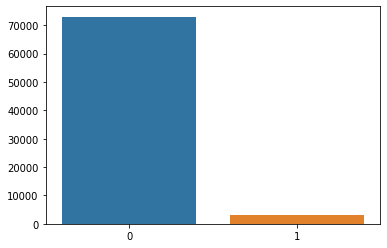

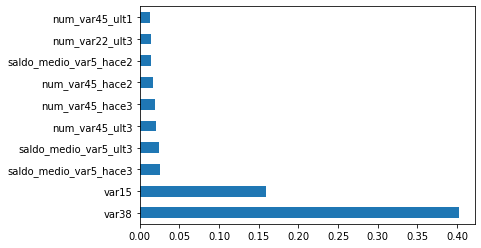

Valores missing:  0
Concluímos que estamos lidando com problema de desbalaceamento de classes, dataset com muitas features e possível multicolinearidade entre variáveis


In [82]:

#Relevancia da TARGET

ax = sns.barplot(["0", "1"], [len(df_treino[df_treino['TARGET']==0]), len(df_treino[df_treino['TARGET']==1])])
print(df_treino['TARGET'].value_counts())
print(df_treino['TARGET'].value_counts(normalize=True))
plt.show(ax)

#Conferindo variáveis importantes - que mais explicam o resultado da TARGET

model = ExtraTreesClassifier()
model.fit(x_treino,y_treino)
#print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=x_treino.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#Checa missing
print("Valores missing: ",len(df_treino.columns[df_treino.isna().sum() > 0]))
print("Concluímos que estamos lidando com problema de desbalaceamento de classes, dataset com muitas features e possível multicolinearidade entre variáveis")

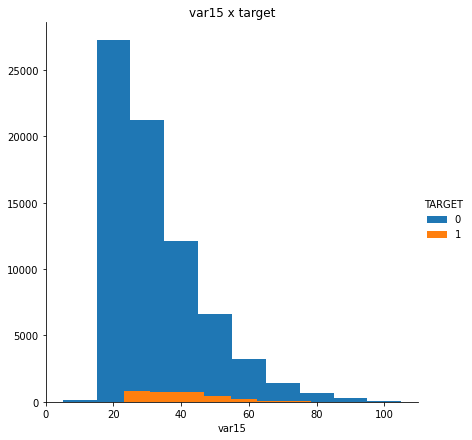

In [78]:
sns.FacetGrid(df_treino, hue="TARGET", size=6) \
   .map(plt.hist, "var15") \
   .add_legend()
plt.title('var15 x target')
plt.show()

In [228]:
#========Pré-processamento e Feature Engeenering========

#Remoção de colunas duplicadas ou com índices iguais

df_treino = df_treino.replace(-999999,2)
df_teste = df_teste.replace(-999999,2)

duplicate_features = get_duplicate_features(df_treino)
duplicate_features_list = duplicate_features.query("Desc=='Duplicate Values'")['feature2'].to_list()
print(duplicate_features_list)

print('Shape antes de remover variaveis duplicadas: ', df_treino.shape)
df_treino.drop(columns = duplicate_features_list, inplace=True)
df_teste.drop(columns = duplicate_features_list, inplace=True)
print('Shape após a remoção de variaveis duplicadas: ', df_treino.shape)


['ind_var2', 'num_var29_0', 'ind_var29_0', 'ind_var29', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var27_0', 'delta_num_trasp_var33_out_1y3', 'ind_var37', 'ind_var39', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var17_out_1y3', 'num_var29', 'saldo_var2_ult1', 'num_var13_medio', 'delta_num_trasp_var17_in_1y3', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'delta_num_reemb_var33_1y3', 'saldo_medio_var13_medio_ult1', 'delta_num_reemb_var17_1y3', 'saldo_medio_var13_medio_hace3', 'ind_var13_medio', 'num_trasp_var33_out_hace3', 'imp_reemb_var33_hace3', 'imp_amort_var34_hace3', 'imp_amort_var18_hace3', 'saldo_var46', 'saldo_var41', 'saldo_var27', 'saldo_var28', 'num_var46', 'num_var46_0', 'num_var41', 'num_var27', 'num_var28', 'num_var28_0', 'num_var27_0', 'ind_var46', 'ind_var46_0', 'ind_var41', 'ind_var27', 'ind_var28', 'ind_var28_0', 'num_trasp_var17_out_hace3', 'imp_reemb_var13_hace3', 'delta_num_r

In [229]:
const_features = get_constant_features(df_treino)
constant_features_list = const_features.query("Desc=='Constant'")['Var'].to_list()
print(constant_features_list)

print('Shape antes de remover variaveis constantes: ', df_treino.shape)
df_treino.drop(columns = constant_features_list, inplace=True)
df_teste.drop(columns = constant_features_list, inplace=True)
print('Shape após a remoção de variaveis constantes: ', df_treino.shape)

['ind_var2_0']
Shape antes de remover variaveis constantes:  (76020, 308)
Shape após a remoção de variaveis constantes:  (76020, 307)


In [230]:
quase_const_features = get_constant_features(df_treino, threshold=0.97,dropna=False)
quase_constant_features_list = quase_const_features.query("Desc=='Quasi Constant'")['Var'].to_list()
print(quase_constant_features_list)

print('Shape antes de remover variaveis quasi constantes (97%): ', df_treino.shape)
df_treino.drop(columns = quase_constant_features_list, inplace=True)
df_teste.drop(columns = quase_constant_features_list, inplace=True)
print('Shape após a remoção de variaveis quasi constantes (97%): ', df_treino.shape)

['num_reemb_var17_hace3', 'imp_trasp_var33_out_ult1', 'num_reemb_var33_ult1', 'num_trasp_var33_out_ult1', 'delta_imp_trasp_var33_out_1y3', 'imp_reemb_var17_hace3', 'imp_reemb_var33_ult1', 'saldo_medio_var29_hace3', 'delta_imp_reemb_var33_1y3', 'saldo_var34', 'saldo_var6', 'num_trasp_var17_in_hace3', 'num_var13_medio_0', 'ind_var34_0', 'num_var18_0', 'num_meses_var13_medio_ult3', 'imp_trasp_var17_in_hace3', 'imp_amort_var18_ult1', 'saldo_medio_var13_medio_hace2', 'saldo_medio_var13_medio_ult3', 'imp_amort_var34_ult1', 'delta_imp_amort_var34_1y3', 'num_var34_0', 'num_var6', 'ind_var6', 'ind_var18_0', 'saldo_var13_medio', 'saldo_var18', 'delta_imp_amort_var18_1y3', 'ind_var13_medio_0', 'saldo_medio_var29_ult3', 'imp_var7_emit_ult1', 'ind_var7_emit_ult1', 'imp_venta_var44_hace3', 'num_venta_var44_hace3', 'num_var7_emit_ult1', 'saldo_medio_var29_ult1', 'imp_trasp_var17_out_ult1', 'imp_trasp_var17_in_ult1', 'num_trasp_var17_in_ult1', 'delta_imp_trasp_var17_out_1y3', 'saldo_medio_var29_hace2'

Shape da base se treino após PCA:  (76020, 45)
Shape da base de teste após PCA:  (75818, 45)


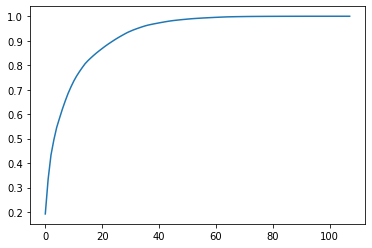

In [232]:


x_treino = df_treino.drop(['TARGET'],axis=1)
y_treino = df_treino['TARGET']

#Aplicação do PCA com 98% de variancia explicada

x_treino_norm = StandardScaler().fit_transform(x_treino)
x_teste_norm = StandardScaler().fit_transform(df_teste)

pca_teste = PCA().fit(x_treino_norm)
cumsum = np.cumsum(pca_teste.explained_variance_ratio_)
plt.plot(cumsum)
d = np.argmax(cumsum >= 0.98) + 1
d 

pca = PCA(n_components=d)

pca_x_treino = pd.DataFrame(pca.fit_transform(x_treino_norm))
pca_x_teste = pd.DataFrame(pca.transform(x_teste_norm))


print('Shape da base se treino após PCA: ',pca_x_treino.shape)
print('Shape da base de teste após PCA: ',pca_x_teste.shape)




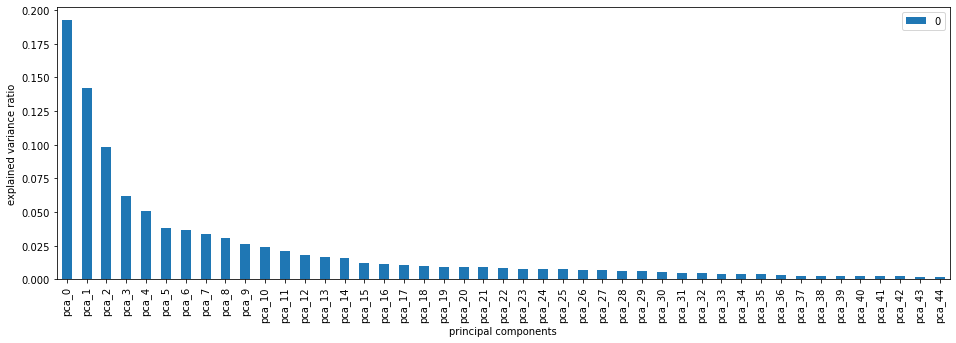

In [233]:
pca_components = ['pca_{}'.format(str(i)) for i in range(d)]
_ = pd.DataFrame(pca.explained_variance_ratio_, index=pca_components).plot.bar(figsize=(16,5))
_ = plt.ylabel('explained variance ratio')
_ = plt.xlabel('principal components')

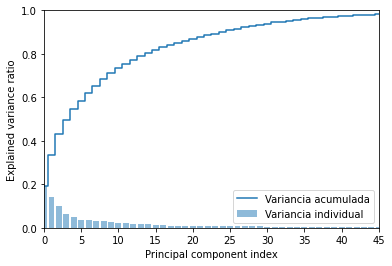

In [234]:
plt.bar(range(0,len(pca_teste.explained_variance_ratio_)), pca_teste.explained_variance_ratio_, alpha=0.5, align='center', label='Variancia individual')
plt.step(range(0,len(cumsum)), cumsum, where='mid',label='Variancia acumulada')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.axis([0, 45, 0, 1])
plt.show()

In [116]:
#Aplicação do Oversampling no público minoritário e avaliar a performance com 5 Folds
#Testando a consistência dos resultados do modelo

sm = SMOTE()

scores = []

cv = KFold(n_splits=3,random_state=42,shuffle=True)
x = 1
for train_fold_index, val_fold_index in cv.split(pca_x_treino, y_treino):

    X_train_fold, y_train_fold = pca_x_treino.iloc[train_fold_index], y_treino[train_fold_index]
    
    X_val_fold, y_val_fold = pca_x_treino.iloc[val_fold_index], y_treino[val_fold_index]

    # Aplicando SMOTE somente dos dados de treino para evitar data leak
    X_train_fold_upsample, y_train_fold_upsample = sm.fit_resample(X_train_fold,y_train_fold)

    print("FOLD nº: " + str(x) + "\n")
    print("Antes do OverSampling, total de insatisfeitos: {}".format(sum(y_train_fold == 1)))
    print("Antes do OverSampling, total de satisfeitos:: {} \n".format(sum(y_train_fold == 0)))

    print('Depois do OverSampling, shape do train_X: {}'.format(X_train_fold_upsample.shape))
    print('Depois do OverSampling, shape do train_y: {} \n'.format(y_train_fold_upsample.shape))

    print("Depois do OverSampling, total de insatisfeitos:  {}".format(sum(y_train_fold_upsample == 1)))
    print("Depois do OverSampling, total de satisfeitos: : {} \n".format(sum(y_train_fold_upsample == 0)))

    GB = GradientBoostingClassifier(n_estimators=100,n_iter_no_change=5, tol=0.01) #Para de fitar quando não houver mudanças de pelo menos 1% na últimas 5 iterações
    GB.fit(X_train_fold_upsample,y_train_fold_upsample)
    print("AUC: " + str(roc_auc_score(y_val_fold, GB.predict_proba(X_val_fold)[:,1])))
    x+=1



FOLD nº: 1

Antes do OverSampling, total de insatisfeitos: 2008
Antes do OverSampling, total de satisfeitos:: 48672 

Depois do OverSampling, shape do train_X: (97344, 45)
Depois do OverSampling, shape do train_y: (97344,) 

Depois do OverSampling, total de insatisfeitos:  48672
Depois do OverSampling, total de satisfeitos: : 48672 

AUC: 0.8084080936729664
FOLD nº: 2

Antes do OverSampling, total de insatisfeitos: 2013
Antes do OverSampling, total de satisfeitos:: 48667 

Depois do OverSampling, shape do train_X: (97334, 45)
Depois do OverSampling, shape do train_y: (97334,) 

Depois do OverSampling, total de insatisfeitos:  48667
Depois do OverSampling, total de satisfeitos: : 48667 

AUC: 0.8176119868184628
FOLD nº: 3

Antes do OverSampling, total de insatisfeitos: 1995
Antes do OverSampling, total de satisfeitos:: 48685 

Depois do OverSampling, shape do train_X: (97370, 45)
Depois do OverSampling, shape do train_y: (97370,) 

Depois do OverSampling, total de insatisfeitos:  48685


In [ ]:
#fit de teste, sem loop

#GB = GradientBoostingClassifier(n_estimators=100,n_iter_no_change=5, tol=0.01) #Para de fitar quando não houver mudanças de pelo menos 1% na últimas 5 iterações
#GB.fit(X_train_fold_upsample,y_train_fold_upsample)

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     73012
           1       0.11      0.76      0.19      3008

    accuracy                           0.74     76020
   macro avg       0.55      0.75      0.52     76020
weighted avg       0.95      0.74      0.82     76020

Melhor Threshold: 0.5071 


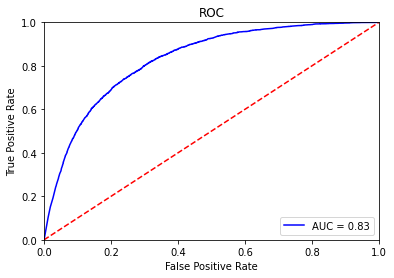

[[54039 18973]
 [  720  2288]]


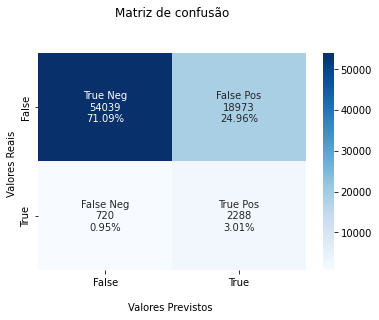

In [121]:
#teste com threshold
#uma leve alteração no threshold das probabilidades de predição eleva meu recall alguns pontos.
from sklearn.metrics import classification_report

y_pred = (GB.predict_proba(pca_x_treino)[:,1]>=0.489).astype(int)
y_pred_proba = GB.predict_proba(pca_x_treino)[:,1]
print(classification_report(y_treino,y_pred))

#plotando a curva ROC

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds = y_pred_proba
preds

fpr, tpr, threshold = metrics.roc_curve(y_treino, preds)
roc_auc = metrics.auc(fpr, tpr)

gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
thresholdOpt = round(threshold[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)

print('Melhor Threshold: {} '.format(thresholdOpt))


# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cf_matrix = confusion_matrix(y_treino, y_pred)
print(cf_matrix)

#visualizando melhor

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Matriz de confusão\n\n');
ax.set_xlabel('\nValores Previstos ')
ax.set_ylabel('Valores Reais ')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

#A curva ROC é uma plotagem para visualizar a relação entre os verdadeiros positivos e os falsos positivos - queremos sempre um número alto de
#verdadeiros positivos e baixos falso positivos. o AUC é a área abaixo dessa cuva, quando mais próximo de 1 melhor é a relação 


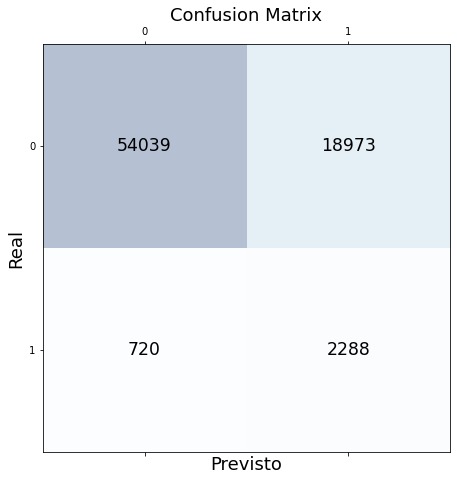

In [122]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Previsto', fontsize=18)
plt.ylabel('Real', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [102]:
#Aplicação do modelo na base teste

y_teste_pred = GB.predict_proba(pca_x_teste)[:,1]
y_teste_pred_df = pd.DataFrame(y_teste_pred)
y_teste_pred_df.columns = ['Prob']
df_teste['TARGET'] = y_teste_pred

submission = pd.DataFrame({"ID":ids, "TARGET":y_teste_pred})
submission.to_csv("submission.csv", index=False)

Resultado Kaggle

![title](score_kaggle.png)

In [123]:
limites = np.linspace(38,80,10)
limites_new = (limites/100)
print(limites_new)


[0.38       0.42666667 0.47333333 0.52       0.56666667 0.61333333
 0.66       0.70666667 0.75333333 0.8       ]


384
502
665
843
1039
1241
1409
1525
1716
2001


<function matplotlib.pyplot.show(close=None, block=None)>

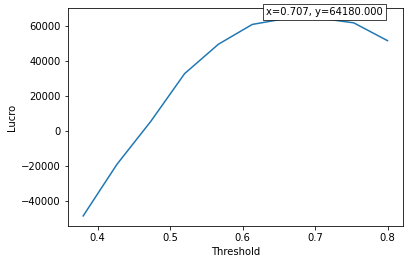

In [124]:

#onde acontece a maximização do lucro?
lucros = []
fns = []
for i in limites_new:
    
    y_pred_aux = (GB.predict_proba(pca_x_treino)[:,1]>=i).astype(int)
    cf_matrix_aux = confusion_matrix(y_treino, y_pred_aux)
    lucros.append((90*cf_matrix_aux[1,1]) - 10*cf_matrix_aux[0,1])
    fns.append(cf_matrix_aux[1,0])
    print(cf_matrix_aux[1,0])


plt.plot(limites_new,lucros) 
# naming the x axis 
plt.xlabel('Threshold') 
# naming the y axis 
plt.ylabel('Lucro')


def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="bottom")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(limites_new,lucros)
plt.show

<b>Case A</b> - Ter uma maximização no lucro implica em ter uma precisão maior, o que implica em permitir falsos negativos o que parece ser prejudicial para o negócio.

Assim, um modelo focado em recall, ou seja, maior assertividade em dizer que o real "insatisfeito" é predito como "insatisfeito" faz com que o benfício por cliente seja melhor estimado, porém gera uma taxa alta de falsos positivos com custo para o negócio. O modelo classificatório acima está numa balança entre ter um bom % de recall e ainda mantendo um lucro positivo, mesmo que baixo.

Só é possível maximizar totalmente o lucro se assumir um risco de classificar como "Satisfeito", pessoas que estavam "Insatisfeitas".

<b>Case B</b> - Atribuir uma nota de 1 a 5 para cada cliente da base de teste. <br>
Utilizei as probabilidades previstas para definir faixas com as notas onde: <br><br>
Menor 20% = Nota 5 <br>
20% ~ 40% = Nota 4 <br>
40% ~ 60% = Nota 3 <br>
60% ~ 80% = Nota 2 <br>
Maior 80% = Nota 1 <br>

Dos casos com nota 1

Assim, os clientes com nota 1 foram classificados com mais de 80% de probabilidade de realmente estarem insatisfeitos.

In [21]:
satisfeitos = np.linspace(0, 0.48, 7)
insatisfeitos = np.linspace(0.5, 1, 4)
bins = [*satisfeitos,*insatisfeitos]
print(bins)
labels = [5,4,3,2,1,5,4,3,2,1]

y_teste_pred_df['Classe'] = np.select([(y_teste_pred_df['Prob'] < 0.489),(y_teste_pred_df['Prob'] >= 0.489)],['0','1'])
y_teste_pred_df['Nota'] = pd.cut(y_teste_pred_df['Prob'], bins=bins,labels=labels,ordered=False)
print(y_teste_pred_df.groupby(["Nota", "Classe"]).size())

satisfeitos1 = len(y_teste_pred_df[(y_teste_pred_df['Nota'] == 1) & (y_teste_pred_df['Classe'] == '0')])
insatisfeitos1 = len(y_teste_pred_df[(y_teste_pred_df['Nota'] == 1) & (y_teste_pred_df['Classe'] == '1')])
print("Lucro previsto para clientes com nota 1: R$", 90*insatisfeitos1 - 10*satisfeitos1)


[0.0, 0.08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.5, 0.6666666666666666, 0.8333333333333333, 1.0]
Nota  Classe
1     0          8359
      1          3251
2     0         11148
      1          5150
3     0         11148
      1         10276
4     0         14053
      1           906
5     0         11527
      1             0
dtype: int64
Lucro previsto para clientes com nota 1: R$ 209000


In [38]:
#2 forma de fazer o case B

satisfeitos = np.linspace(0, 0.48, 7)
insatisfeitos = np.linspace(0.5, 1, 4)
todos = np.linspace(0.0,1.0,6)
bins = [todos]
print(bins)
labels = [5,4,3,2,1]


[array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])]


In [127]:
y_pred_treino = pca_x_treino
y_pred_treino['Prob'] = y_pred_proba
y_pred_treino['TARGET'] = y_treino

0    73012
1     3008
Name: TARGET, dtype: int64


In [129]:
#usando a base de treino

y_pred_proba

y_pred_treino['Classe'] = np.select([(y_pred_treino['Prob'] < 0.489),(y_pred_treino['Prob'] >= 0.489)],['0','1'])
y_pred_treino['Nota'] = pd.cut(y_pred_treino['Prob'], bins=[0. , 0.2, 0.4, 0.6, 0.8, 1. ],labels=[5,4,3,2,1])
print(y_pred_treino.groupby(["Nota"]).size())

print(y_pred_treino.groupby(["Nota","TARGET"]).size())

Nota
5    23499
4    23237
3    17003
2     7351
1     4930
dtype: int64
Nota  TARGET
5     0         23414
      1            85
4     0         22881
      1           356
3     0         16260
      1           743
2     0          6534
      1           817
1     0          3923
      1          1007
dtype: int64


In [131]:
y_teste_pred_df['Classe'] = np.select([(y_teste_pred_df['Prob'] < 0.489),(y_teste_pred_df['Prob'] >= 0.489)],['0','1'])
y_teste_pred_df['Nota'] = pd.cut(y_teste_pred_df['Prob'], bins=[0. , 0.2, 0.4, 0.6, 0.8, 1. ],labels=[5,4,3,2,1])
print(y_teste_pred_df.groupby(["Nota"]).size())
#print("Lucro previsto para clientes com nota 1: R$", 90*insatisfeitos1 - 10*satisfeitos1)


Nota
5    26341
4    22394
3    16221
2     6390
1     4472
dtype: int64


![title](caseb_1.png)

<b>Case C</b> - Encontrar os 3 grupos naturais onde os maiores lucros esperados por cliente.

(76020, 24)

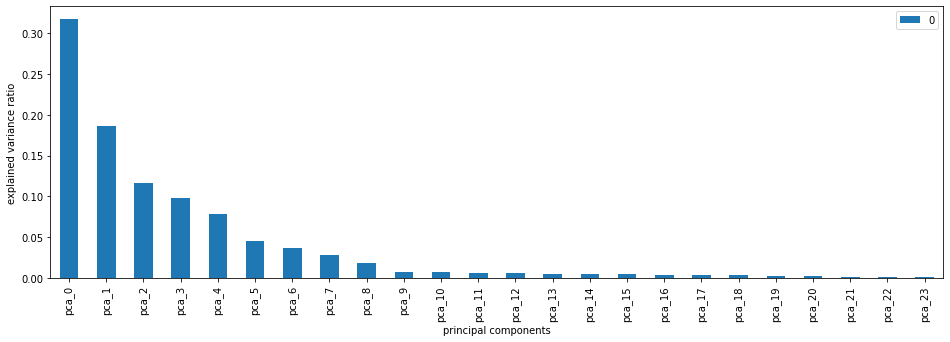

In [185]:
#usando a base de treino

#y_pred_treino
from sklearn.preprocessing import MinMaxScaler
#refazendo o pca com 90% da variancia
x_treino_norm = MinMaxScaler().fit_transform(x_treino) #xtreino é a base de teste sem duplicidades ou correlações
pca_teste = PCA().fit(x_treino_norm)
cumsum = np.cumsum(pca_teste.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1
d 

pca = PCA(n_components=d)

pca_x_treino_kmeans = pd.DataFrame(pca.fit_transform(x_treino_norm))


pca_components = ['pca_{}'.format(str(i)) for i in range(d)]
_ = pd.DataFrame(pca.explained_variance_ratio_, index=pca_components).plot.bar(figsize=(16,5))
_ = plt.ylabel('explained variance ratio')
_ = plt.xlabel('principal components')


X_kmeans = pca_x_treino_kmeans

pca_x_treino_kmeans.shape

In [188]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X_kmeans)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

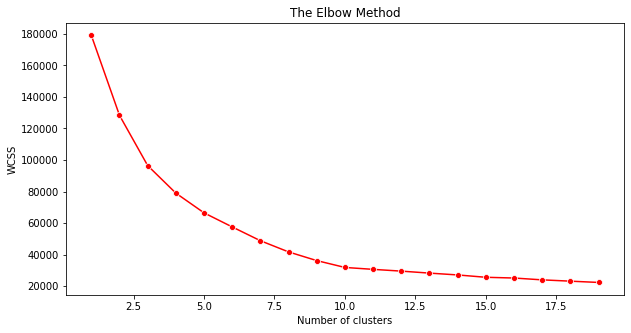

In [189]:

plt.figure(figsize=(10,5))
sns.lineplot(range(1, 20), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [191]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 20), wcss, curve="convex", direction="decreasing")
kl.elbow

7

In [ ]:
from sklearn.metrics import silhouette_samples,silhouette_score
for i in range(2,10):

    kmeans = KMeans(n_clusters = i, init = 'k-means++',random_state=42)
    y_kmeans = kmeans.fit_predict(X_kmeans)
    
    silhouette_avg = silhouette_score(X_kmeans,y_kmeans)
    print(silhouette_avg)

    #Calculate the silhouette score for each data
    each_silhouette_score = silhouette_samples(X_kmeans,y_kmeans,metric="euclidean")

    colorlist =["tomato","antiquewhite","blueviolet","cornflowerblue","darkgreen","seashell","skyblue","mediumseagreen"]
    fig =plt.figure()
    ax = fig.add_subplot(1,1,1)
    y_lower =10
    for i in range(i):
        ith_cluster_silhouette_values = each_silhouette_score[y_kmeans == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = colorlist[i]
        ax.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.3)
        
        #label the silhouse plots with their cluster numbers at the middle
        ax.text(-0.05,y_lower + 0.5 * size_cluster_i,str(i))
        
        #compute the new y_lower for next plot
        y_lower = y_upper +10 
        
    #ax.set_title("Silhuoette plot")
    #ax.set_xlabel("silhouette score")
    #ax.set_ylabel("Cluster label")
        
    #the vertical line for average silhouette score of all the values
    #ax.axvline(x=silhouette_avg,color="red",linestyle="--")
        
    #ax.set_yticks([])
    #ax.set_xticks([-0.2,0,0.2,0.4,0.6,0.8,1])

In [204]:
    kmeans = KMeans(n_clusters = kl.elbow, init = 'k-means++',random_state=42)
    y_kmeans = kmeans.fit_predict(X_kmeans)
    

In [205]:
kmeans_final = pd.DataFrame(X_kmeans)
kmeans_final['TARGET'] = y_treino
kmeans_final['GRUPOS'] = y_kmeans

In [219]:
tabela = pd.crosstab(kmeans_final['GRUPOS'],kmeans_final['TARGET'])
tabela['Total'] = tabela[0] + tabela[1]
tabela['Lucro Máximo'] = (tabela[1]*90)
tabela['Lucro Obtido'] = (tabela[1]*90) - (tabela[0]*10)
tabela.sort_values(by='Lucro Obtido', ascending=False)

TARGET,0,1,Total,Lucro Máximo,Lucro Obtido
GRUPOS,,,,,
0,6250,614,6864,55260,-7240
2,14307,1318,15625,118620,-24450
6,2680,23,2703,2070,-24730
5,3054,24,3078,2160,-28380
3,4601,164,4765,14760,-31250
4,4086,75,4161,6750,-34110
1,38034,790,38824,71100,-309240


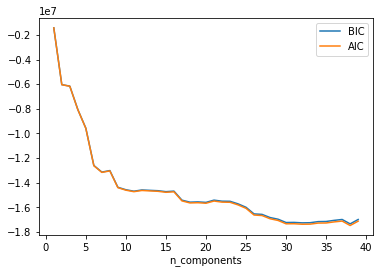

In [248]:
#tentativa com GMM
from sklearn.mixture import GaussianMixture
n_components = np.arange(1, 40)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_kmeans) for n in n_components]
plt.plot(n_components, [m.bic(X_kmeans) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_kmeans) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [242]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X_kmeans)

GaussianMixture(n_components=4)

In [243]:
labels = gmm.predict(X_kmeans)

In [244]:
labels

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

In [245]:
kmeans_final_gmm = pd.DataFrame(X_kmeans)
kmeans_final_gmm['TARGET'] = y_treino
kmeans_final_gmm['GRUPOS'] = labels

tabela = pd.crosstab(kmeans_final_gmm['GRUPOS'],kmeans_final_gmm['TARGET'])
tabela['Total'] = tabela[0] + tabela[1]
tabela['Lucro Máximo'] = (tabela[1]*90)
tabela['Lucro Obtido'] = (tabela[1]*90) - (tabela[0]*10)
tabela.sort_values(by='Lucro Obtido', ascending=False)

TARGET,0,1,Total,Lucro Máximo,Lucro Obtido
GRUPOS,,,,,
2,10050,1008,11058,90720,-9780
3,7968,521,8489,46890,-32790
0,21576,1382,22958,124380,-91380
1,33418,97,33515,8730,-325450
